In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import torch
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    RobertaTokenizerFast,
    RobertaForSequenceClassification,
    Trainer,
    TrainingArguments
)

from sklearn.utils import resample

import warnings
warnings.filterwarnings('ignore')

In [19]:
import os

if not os.path.exists("saved_models"):
    os.makedirs("saved_models")

In [2]:
# Load dataset
df = pd.read_csv("Tweets.csv")

# Focus on relevant columns
df = df[['text', 'airline_sentiment']].dropna()

# Map sentiment to numeric labels
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['airline_sentiment'].map(label_map)

# Quick look at class distribution
sentiment_counts = df['airline_sentiment'].value_counts()

In [3]:
df

,text,airline_sentiment,label
0,@VirginAmerica What @dhepburn said.,neutral,1
1,@VirginAmerica plus you've added commercials t...,positive,2
2,@VirginAmerica I didn't today... Must mean I n...,neutral,1
3,@VirginAmerica it's really aggressive to blast...,negative,0
4,@VirginAmerica and it's a really big bad thing...,negative,0
...,...,...,...
14635,@AmericanAir thank you we got on a different f...,positive,2
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative,0
14637,@AmericanAir Please bring American Airlines to...,neutral,1
14638,"@AmericanAir you have my money, you change my ...",negative,0


In [4]:
# Function to extract first @mention
def extract_flight_handle(text):
    match = re.search(r'@(\w+)', text)
    if match:
        return match.group(1)   # Extract without '@'
    else:
        return 'Unknown'

# Apply to create new column
df['flight_handle'] = df['text'].apply(extract_flight_handle)

# Check the first few rows
print(df[['text', 'flight_handle']].head())

                                                text  flight_handle
0                @VirginAmerica What @dhepburn said.  VirginAmerica
1  @VirginAmerica plus you've added commercials t...  VirginAmerica
2  @VirginAmerica I didn't today... Must mean I n...  VirginAmerica
3  @VirginAmerica it's really aggressive to blast...  VirginAmerica
4  @VirginAmerica and it's a really big bad thing...  VirginAmerica


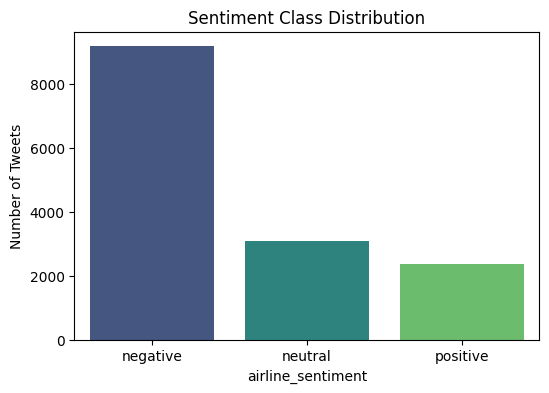


Class Distribution:
 airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64


In [5]:
plt.figure(figsize=(6,4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title("Sentiment Class Distribution")
plt.ylabel("Number of Tweets")
plt.show()

print("\nClass Distribution:\n", sentiment_counts)

In [6]:
# Preprocessing & Class Balancing


# Basic text cleaning function
def clean_text(text):
    text = re.sub(r"http\S+", " ", text)             # Remove URLs
    text = re.sub(r"@\w+", " ", text)                # Remove mentions
    text = re.sub(r"#", "", text)                    # Remove only '#' but keep the word
    text = re.sub(r"[^A-Za-z0-9\s]", " ", text)      # Remove special characters
    text = re.sub(r"\s+", " ", text)                 # Replace multiple spaces with single space
    return text.lower().strip()

# Apply cleaning
df['clean_text'] = df['text'].apply(clean_text)

# Check cleaned example
print("\nSample cleaned tweet:\n", df['clean_text'].iloc[0])


Sample cleaned tweet:
 what said


In [7]:
# Apply cleaning
df['clean_text'] = df['text'].apply(clean_text)

# Filter: Remove tweets with less than 3 words after cleaning
df['clean_text'] = df['clean_text'].apply(lambda x: x if len(x.split()) >= 3 else np.nan)

# Drop empty/short tweets
df = df.dropna(subset=['clean_text']).reset_index(drop=True)

# Check example again
print("\nOriginal Tweet:\n", df['text'].iloc[0])
print("Cleaned Tweet:\n", df['clean_text'].iloc[0])


Original Tweet:
 @VirginAmerica plus you've added commercials to the experience... tacky.
Cleaned Tweet:
 plus you ve added commercials to the experience tacky


In [8]:
SEED = 42

# Split classes
negative_df = df[df['label'] == 0]
neutral_df = df[df['label'] == 1]
positive_df = df[df['label'] == 2]

# Upsample neutral and positive to match negative count
neutral_upsampled = resample(neutral_df,
                             replace=True,
                             n_samples=len(negative_df),
                             random_state=SEED)

positive_upsampled = resample(positive_df,
                              replace=True,
                              n_samples=len(negative_df),
                              random_state=SEED)

# Combine to form balanced dataset
df_balanced = pd.concat([negative_df, neutral_upsampled, positive_upsampled])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=SEED).reset_index(drop=True)

# Verify new class distribution
print("\nBalanced Class Distribution:\n", df_balanced['label'].value_counts())


Balanced Class Distribution:
 label
0    9124
1    9124
2    9124
Name: count, dtype: int64


In [9]:
df.head()

,text,airline_sentiment,label,flight_handle,clean_text
0,@VirginAmerica plus you've added commercials t...,positive,2,VirginAmerica,plus you ve added commercials to the experienc...
1,@VirginAmerica I didn't today... Must mean I n...,neutral,1,VirginAmerica,i didn t today must mean i need to take anothe...
2,@VirginAmerica it's really aggressive to blast...,negative,0,VirginAmerica,it s really aggressive to blast obnoxious ente...
3,@VirginAmerica and it's a really big bad thing...,negative,0,VirginAmerica,and it s a really big bad thing about it
4,@VirginAmerica seriously would pay $30 a fligh...,negative,0,VirginAmerica,seriously would pay 30 a flight for seats that...


In [14]:
# Baseline: TF-IDF + Logistic Regression

# Use the balanced dataset for fair comparison
X = df_balanced['clean_text']
y = df_balanced['label']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

# Fit and transform the training data, transform the test data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Initialize Logistic Regression
lr_model = LogisticRegression(max_iter=200, random_state=SEED)

# Train the model
lr_model.fit(X_train_tfidf, y_train)

# Predict on test set
y_pred = lr_model.predict(X_test_tfidf)

# Evaluation
print("\nClassification Report (TF-IDF + Logistic Regression):\n")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))


Classification Report (TF-IDF + Logistic Regression):

              precision    recall  f1-score   support

    Negative       0.86      0.82      0.84      1825
     Neutral       0.82      0.85      0.84      1825
    Positive       0.90      0.91      0.90      1825

    accuracy                           0.86      5475
   macro avg       0.86      0.86      0.86      5475
weighted avg       0.86      0.86      0.86      5475



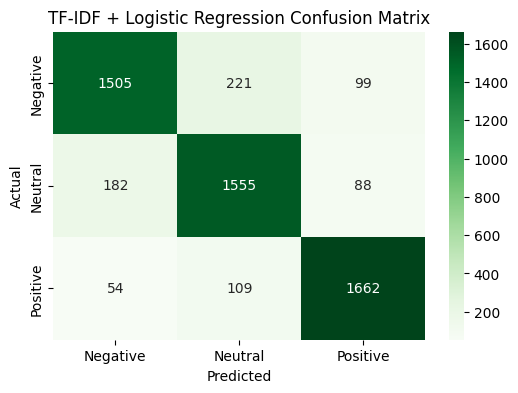

In [15]:
# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("TF-IDF + Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [20]:
import joblib

joblib.dump(lr_model, "saved_models/tfidf_logistic_regression.pkl")
joblib.dump(tfidf, "saved_models/tfidf_vectorizer.pkl")

print("Saved TF-IDF + Logistic Regression model and vectorizer.")

Saved TF-IDF + Logistic Regression model and vectorizer.


In [11]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is

In [12]:
from datasets import Dataset

In [17]:
# Prepare Dataset
train_df, test_df = train_test_split(df_balanced, test_size=0.2, stratify=df_balanced['label'], random_state=SEED)

train_dataset = Dataset.from_pandas(train_df[['clean_text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['clean_text', 'label']])

In [20]:
# DistilBERT Fine-Tuning

from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
import numpy as np
from datasets import Dataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load tokenizer and model
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
distilbert_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

# Tokenization function
def tokenize_batch(batch):
    return distilbert_tokenizer(batch['clean_text'], padding=True, truncation=True)

# Apply tokenization
train_dataset = train_dataset.map(tokenize_batch, batched=True)
test_dataset = test_dataset.map(tokenize_batch, batched=True)

# Set format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Training arguments (Adjusted for older transformers)
training_args = TrainingArguments(
    output_dir="./distilbert_results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=1,
    logging_dir="./distilbert_logs",
    logging_steps=50
)

# Initialize Trainer
trainer = Trainer(
    model=distilbert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=distilbert_tokenizer
)

# Train the model
trainer.train()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/21897 [00:00<?, ? examples/s]

Map:   0%|          | 0/5475 [00:00<?, ? examples/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ajhnavi84 (ajhnavi84-uc-san-diego) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
50,0.992800
100,0.722900
150,0.623900
200,0.572500


Step,Training Loss
50,0.992800
100,0.722900
150,0.623900
200,0.572500
250,0.588500
300,0.535300
350,0.492300
400,0.533300
450,0.463700
500,0.455200


TrainOutput(global_step=4107, training_loss=0.2635978406468882, metrics={'train_runtime': 15768.2455, 'train_samples_per_second': 4.166, 'train_steps_per_second': 0.26, 'total_flos': 759121329038058.0, 'train_loss': 0.2635978406468882, 'epoch': 3.0})


Classification Report (DistilBERT):

              precision    recall  f1-score   support

    Negative       0.95      0.88      0.92      1825
     Neutral       0.90      0.94      0.92      1825
    Positive       0.96      0.98      0.97      1825

    accuracy                           0.94      5475
   macro avg       0.94      0.94      0.94      5475
weighted avg       0.94      0.94      0.94      5475



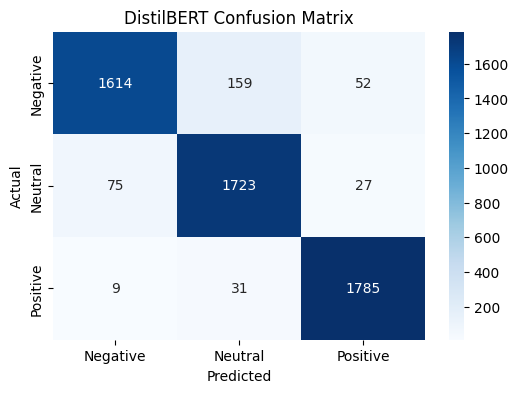

In [21]:
# Predict on test set
pred_output = trainer.predict(test_dataset)
y_pred_distilbert = np.argmax(pred_output.predictions, axis=1)
y_true_distilbert = pred_output.label_ids

# Classification report
print("\nClassification Report (DistilBERT):\n")
print(classification_report(y_true_distilbert, y_pred_distilbert, target_names=['Negative', 'Neutral', 'Positive']))

# Confusion Matrix
cm_distilbert = confusion_matrix(y_true_distilbert, y_pred_distilbert)

plt.figure(figsize=(6,4))
sns.heatmap(cm_distilbert, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("DistilBERT Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
distilbert_model.save_pretrained("saved_models/distilbert_sentiment")
distilbert_tokenizer.save_pretrained("saved_models/distilbert_sentiment")

print("Saved DistilBERT model and tokenizer.")

In [18]:
# Transformer Model: Twitter-RoBERTa

# Load tokenizer and model
roberta_model_name = "cardiffnlp/twitter-roberta-base"
roberta_tokenizer = RobertaTokenizerFast.from_pretrained(roberta_model_name)
roberta_model = RobertaForSequenceClassification.from_pretrained(roberta_model_name, num_labels=3)

# Tokenization function for RoBERTa
def tokenize_roberta(batch):
    return roberta_tokenizer(batch['clean_text'], padding=True, truncation=True)

# Reuse the same train/test split from before
train_dataset_roberta = Dataset.from_pandas(train_df[['clean_text', 'label']])
test_dataset_roberta = Dataset.from_pandas(test_df[['clean_text', 'label']])

# Apply tokenization
train_dataset_roberta = train_dataset_roberta.map(tokenize_roberta, batched=True)
test_dataset_roberta = test_dataset_roberta.map(tokenize_roberta, batched=True)

# Set format for PyTorch
train_dataset_roberta.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset_roberta.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Training arguments
training_args_roberta = TrainingArguments(
    output_dir="./roberta_results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=1,
    logging_dir="./roberta_logs",
    logging_steps=50
)

# Initialize Trainer
trainer_roberta = Trainer(
    model=roberta_model,
    args=training_args_roberta,
    train_dataset=train_dataset_roberta,
    eval_dataset=test_dataset_roberta,
    tokenizer=roberta_tokenizer
)

# Train Twitter-RoBERTa
trainer_roberta.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/21897 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/5475 [00:00<?, ? examples/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ajhnavi84 (ajhnavi84-uc-san-diego) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
50,0.922700
100,0.616200
150,0.531600
200,0.521700
250,0.507100
300,0.442800
350,0.443500
400,0.437600
450,0.395700
500,0.402500


Step,Training Loss
50,0.922700
100,0.616200
150,0.531600
200,0.521700
250,0.507100
300,0.442800
350,0.443500
400,0.437600
450,0.395700
500,0.402500


TrainOutput(global_step=4107, training_loss=0.23206491147569128, metrics={'train_runtime': 38080.0651, 'train_samples_per_second': 1.725, 'train_steps_per_second': 0.108, 'total_flos': 1550301257577744.0, 'train_loss': 0.23206491147569128, 'epoch': 3.0})


Classification Report (Twitter-RoBERTa):

              precision    recall  f1-score   support

    Negative       0.96      0.90      0.93      1825
     Neutral       0.92      0.95      0.94      1825
    Positive       0.96      0.99      0.97      1825

    accuracy                           0.95      5475
   macro avg       0.95      0.95      0.95      5475
weighted avg       0.95      0.95      0.95      5475



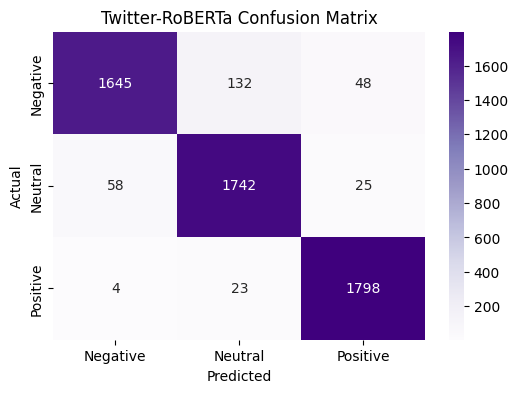

In [21]:
# Predict on test set
pred_output_roberta = trainer_roberta.predict(test_dataset_roberta)

# Get predictions and true labels
y_pred_roberta = np.argmax(pred_output_roberta.predictions, axis=1)
y_true_roberta = pred_output_roberta.label_ids

# Classification Report
print("\nClassification Report (Twitter-RoBERTa):\n")
print(classification_report(y_true_roberta, y_pred_roberta, target_names=['Negative', 'Neutral', 'Positive']))

# Confusion Matrix
cm_roberta = confusion_matrix(y_true_roberta, y_pred_roberta)

plt.figure(figsize=(6,4))
sns.heatmap(cm_roberta, annot=True, fmt='d', cmap='Purples', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title("Twitter-RoBERTa Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [22]:
roberta_model.save_pretrained("saved_models/roberta_sentiment")
roberta_tokenizer.save_pretrained("saved_models/roberta_sentiment")

print("Saved Twitter-RoBERTa model and tokenizer.")

Saved Twitter-RoBERTa model and tokenizer.


In [23]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=6ff96eb1bea73d825dabab8d9973531ea0d5eb1211617009a0fe577c8fca9132
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [2]:
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification

# Load the fine-tuned model from saved directory
roberta_tokenizer = RobertaTokenizerFast.from_pretrained("saved_models/roberta_sentiment")
roberta_model = RobertaForSequenceClassification.from_pretrained("saved_models/roberta_sentiment")

In [1]:
# ========================================
# 🧠 LIME Explainability for Twitter-RoBERTa (Optimized)
# ========================================

from lime.lime_text import LimeTextExplainer
import numpy as np
import torch

# 1️⃣ Load Fine-Tuned Twitter-RoBERTa Model & Tokenizer
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification

roberta_tokenizer = RobertaTokenizerFast.from_pretrained("saved_models/roberta_sentiment")
roberta_model = RobertaForSequenceClassification.from_pretrained("saved_models/roberta_sentiment")

# 2️⃣ Define Class Names
class_names = ['Negative', 'Neutral', 'Positive']

# 3️⃣ Define Prediction Function for LIME
def predict_proba(texts):
    tokens = roberta_tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=128)
    with torch.no_grad():
        outputs = roberta_model(**tokens)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    return probs.cpu().numpy()

# 4️⃣ Initialize LIME Text Explainer
explainer = LimeTextExplainer(class_names=class_names)

# 5️⃣ Choose a Short Sample Tweet to Explain
sample_tweet = "Worst flight ever. Delayed and rude staff!"

# 6️⃣ Generate Explanation (Reduced num_samples to avoid RAM crash)
exp = explainer.explain_instance(
    sample_tweet,
    predict_proba,
    num_features=8,
    num_samples=500   # Reduce load from default 5000
)

# 7️⃣ Get Predicted Class
predicted_class = np.argmax(predict_proba([sample_tweet]))
print(f"\nPredicted Sentiment: {class_names[predicted_class]}")

# 8️⃣ Display Explanation
try:
    exp.show_in_notebook(text=True)
except:
    print("\nTop words influencing prediction:")
    for word, weight in exp.as_list(label=predicted_class):
        print(f"{word}: {weight:.4f}")

# 9️⃣ Optionally Save as HTML
exp.save_to_file('lime_explanation.html')
print("\nLIME explanation saved as 'lime_explanation.html'")


Predicted Sentiment: Negative



LIME explanation saved as 'lime_explanation.html'


In [12]:
# Predict Sentiment Function

import torch

# Load the fine-tuned model & tokenizer (if not already loaded)
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification

roberta_tokenizer = RobertaTokenizerFast.from_pretrained("saved_models/roberta_sentiment")
roberta_model = RobertaForSequenceClassification.from_pretrained("saved_models/roberta_sentiment")

# Define class labels
class_labels = ['Negative', 'Neutral', 'Positive']

# Define prediction function
def predict_sentiment(text):
    roberta_model.eval()  # Set model to evaluation mode
    tokens = roberta_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)

    with torch.no_grad():
        outputs = roberta_model(**tokens)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)

    predicted_class = torch.argmax(probs, dim=1).item()
    confidence = probs[0][predicted_class].item()

    return {
        "Text": text,
        "Predicted Sentiment": class_labels[predicted_class],
        "Confidence": f"{confidence*100:.2f}%"
    }

def print_result(text, expected_sentiment):
    result = predict_sentiment(text)
    print(f"Sentence: {result['Text']}")
    print(f"Expected: {expected_sentiment}")
    print(f"Predicted: {result['Predicted Sentiment']}  |  Confidence: {result['Confidence']}")
    print("-" * 60)

# Example Usage
print_result("I love how smooth the flight was, great service!", "Positive")
print_result("First class service as always—stood in line for only 2 hours!", "Negative")
print_result("Impressed by how long they can keep us waiting. True dedication!", "Negative")
print_result("Oh perfect, no WiFi on a 6-hour flight. Exactly how I wanted to spend my time.", "Negative")
print_result("Terrible experience. Flight delayed and lost baggage.", "Negative")
print_result("Boarding completed on time. Waiting for takeoff.", "Neutral")
print_result("Landed safely at the destination.", "Neutral")
print_result("Flight scheduled for 3 PM tomorrow.", "Neutral")

Sentence: I love how smooth the flight was, great service!
Expected: Positive
Predicted: Positive  |  Confidence: 99.96%
------------------------------------------------------------
Sentence: First class service as always—stood in line for only 2 hours!
Expected: Negative
Predicted: Positive  |  Confidence: 89.69%
------------------------------------------------------------
Sentence: Impressed by how long they can keep us waiting. True dedication!
Expected: Negative
Predicted: Positive  |  Confidence: 99.87%
------------------------------------------------------------
Sentence: Oh perfect, no WiFi on a 6-hour flight. Exactly how I wanted to spend my time.
Expected: Negative
Predicted: Negative  |  Confidence: 99.87%
------------------------------------------------------------
Sentence: Terrible experience. Flight delayed and lost baggage.
Expected: Negative
Predicted: Negative  |  Confidence: 99.78%
------------------------------------------------------------
Sentence: Boarding complet